In [1]:
import pandas as pd
import numpy as np 
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adagrad
import random
from solution import solution
import time
import scipy
from sklearn.metrics import mean_squared_error

In [2]:
#load autoencoder model 
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation="relu")(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
anomalyDetector = tf.keras.Model(inputs=input_layer, outputs=decoder)
anomalyDetector.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
 dense_3 (Dense)             (None, 2)                 4         
                                                                 
 dense_4 (Dense)             (None, 3)                 9         
                                                                 
 dense_5 (Dense)             (None, 4)                 16    

2022-03-11 15:29:42.250731: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 15:29:47.386166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14104 MB memory:  -> device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-03-11 15:29:47.390295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14592 MB memory:  -> device: 1, name: Tesla V100-DGXS-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2022-03-11 15:29:47.393777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

In [3]:
anomalyDetector.load_weights('AE_tuneActivation_code_relu.h5')

In [4]:
dataset = pd.read_csv("GMM_values.csv", header=0)

#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])
        
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None
    
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)
    
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul

#get starting points 
startingPoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        timePoint = row['Timestep'] + 1
        startingPoints.append(timePoint)

def getTimeFromStart(current, startList):
    currentEpisodeStartIndex = -1 #initialise negative value first
    for s in range(len(startList)):
        start = startList[s]
        if start - current > 0: 
            break 
        currentEpisodeStartIndex = s
    if currentEpisodeStartIndex >= 0:
        startPointTime = startList[currentEpisodeStartIndex]
        diff = current - startPointTime
        return int(diff)
    else: 
        return current

#get data on time elapsed from start of episode 
total_time_from_start = []
for timePoint in timeX:
    current_time_from_start = getTimeFromStart(timePoint, startingPoints)
    total_time_from_start.append(current_time_from_start)
    
all_df['Time_elapsed'] = total_time_from_start

anomalyData = []

for index, row in all_df.iterrows():
    sensorReadings = np.array([row['Volt'], row['Rotate'], row['Pressure'], row['Vibration']])
    sensorReadings = np.reshape(sensorReadings, (1,4))
    predictions = anomalyDetector.predict(sensorReadings)
    anomalyScore = (np.mean(np.power(sensorReadings - predictions, 2), axis=1))**0.5
    
    if anomalyScore < 0.0838:
        isAnomaly = 0
    else:
        isAnomaly = 1
        
    anomalyData.append(isAnomaly)
    
all_df['Anomalous'] = anomalyData

#drop na columns 
all_df = all_df.dropna()

In [5]:
#data processing
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['Time_elapsed'], row['Anomalous'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)
        
num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

#split into training, validation and test sets
train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [6]:
def splitDataIntoChunks3DWithAnomalyTimeInfo(data, chunk_size):
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:7])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][7])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [7]:
#set random seed 
tf.random.set_seed(42)

In [8]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

In [9]:
(trainX_4step_TAD, trainY_4step_TAD, trainTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(train_data, 4)
(valX_4step_TAD, valY_4step_TAD, valTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(val_data, 4)
(testX_4step_TAD, testY_4step_TAD, testTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(test_data, 4)

trainX_4step_TAD_arr = np.array(trainX_4step_TAD)
trainY_4step_TAD_arr = np.array(trainY_4step_TAD)
trainY_4step_TAD_arr = trainY_4step_TAD_arr.reshape(-1, 1)

valX_4step_TAD_arr = np.array(valX_4step_TAD)
valY_4step_TAD_arr = np.array(valY_4step_TAD)
valY_4step_TAD_arr = valY_4step_TAD_arr.reshape(-1, 1)

In [10]:
#build model architecture 
model = models.Sequential()
model.add(layers.Conv1D(filters=3125, kernel_size=3, activation='relu', input_shape=(4, 6), padding="same"))
model.add(layers.Conv1D(filters=459, kernel_size=2, activation='relu', padding="same"))
model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model.add(layers.Dropout(0.5396))
model.add(layers.Conv1D(filters=80, kernel_size=1, activation='relu'))
model.add(layers.Dropout(0))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0458, beta_2=0.7899, epsilon=0.1)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [12]:
#save best model
fileName = "CNN_tuned_withTime2.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [13]:
learning_model1 = model.fit(trainX_4step_TAD_arr, trainY_4step_TAD_arr, epochs=500, batch_size=32, validation_data=(valX_4step_TAD_arr, valY_4step_TAD_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500


2022-03-11 15:45:19.855828: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


126/126 [==============================] - 4s 12ms/step - loss: 31.1075 - mean_squared_error: 31.1075 - val_loss: 16.9288 - val_mean_squared_error: 16.9288
Epoch 2/500
126/126 [==============================] - 1s 8ms/step - loss: 23.1204 - mean_squared_error: 23.1204 - val_loss: 9.9827 - val_mean_squared_error: 9.9827
Epoch 3/500
126/126 [==============================] - 1s 9ms/step - loss: 18.2373 - mean_squared_error: 18.2373 - val_loss: 8.6740 - val_mean_squared_error: 8.6740
Epoch 4/500
126/126 [==============================] - 1s 9ms/step - loss: 17.6458 - mean_squared_error: 17.6458 - val_loss: 8.6494 - val_mean_squared_error: 8.6494
Epoch 5/500
126/126 [==============================] - 1s 8ms/step - loss: 17.5141 - mean_squared_error: 17.5141 - val_loss: 8.6202 - val_mean_squared_error: 8.6202
Epoch 6/500
126/126 [==============================] - 1s 9ms/step - loss: 17.5824 - mean_squared_error: 17.5824 - val_loss: 8.5986 - val_mean_squared_error: 8.5986
Epoch 7/500
126/126

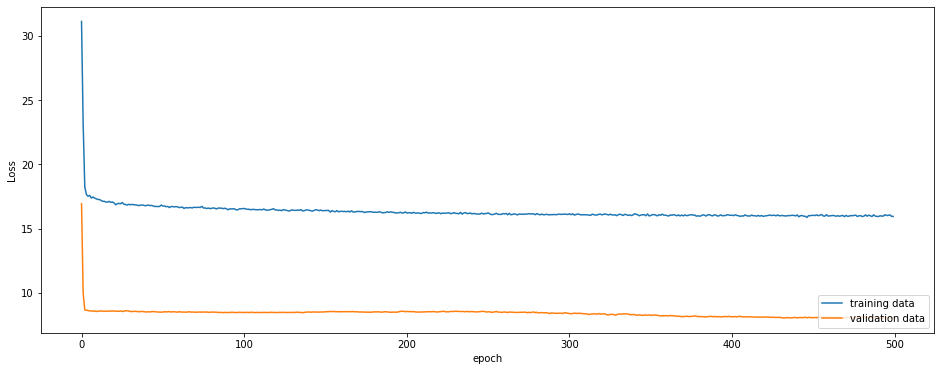

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.plot(learning_model1.history['loss'])
plt.plot(learning_model1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [15]:
model1 = tf.keras.models.load_model("CNN_tuned_withTime2.h5")

In [16]:
#performance on training set
trainPredict1 = model1.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict1))
trainR2Score1 = r2_score(trainY_4step_TAD_arr, trainPredict1)
trainSscore1 = findSscore(trainY_4step_TAD_arr, trainPredict1)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore1, trainR2Score1, trainSscore1))

Train Score: 4.0311 RMSE 0.1296 R2 Score 5325.8737 S score


In [17]:
#performance on validation set
valPredict1 = model1.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore1 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict1))
valR2Score1 = r2_score(valY_4step_TAD_arr, valPredict1)
valSscore1 = findSscore(valY_4step_TAD_arr, valPredict1)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore1, valR2Score1, valSscore1))

Validation Score: 2.8366 RMSE 0.2976 R2 Score 785.6241 S score


In [18]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

In [19]:
allRUL = all_df['RUL']

In [20]:
(actualTrain1, predictedTrain1) = getRULValues(trainPredict1, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal1, predictedVal1) = getRULValues(valPredict1, allRUL, valTime_4step_TAD, 6010, 6976)

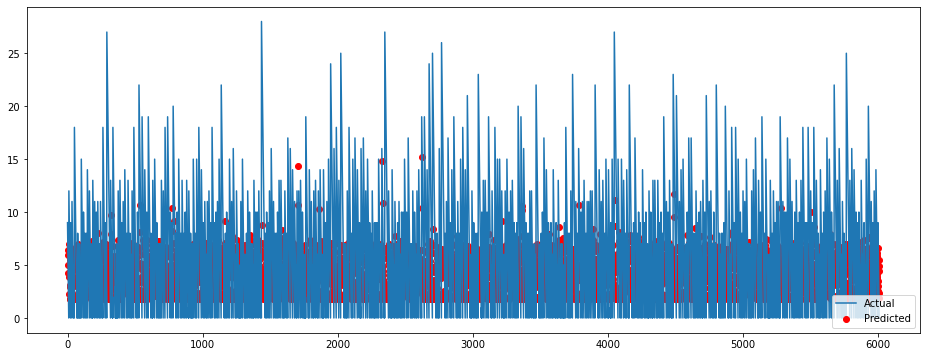

In [21]:
#training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain1)
plt.scatter(trainTime_4step_TAD, trainPredict1, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


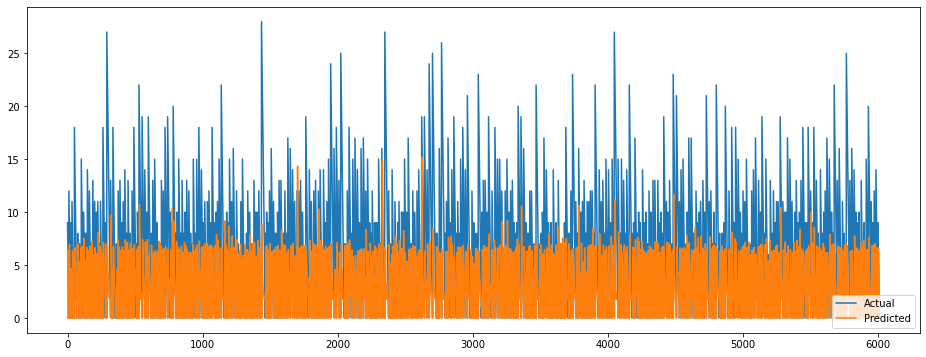

In [22]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain1)
plt.plot(trainTimeLabels, predictedTrain1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

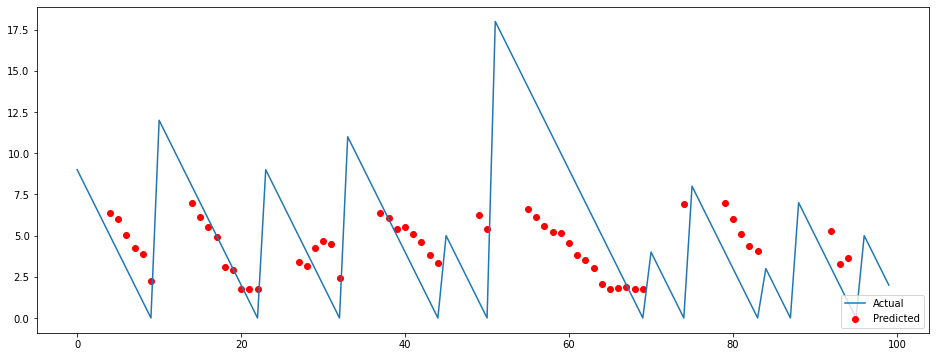

In [23]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain1[0:100])
plt.scatter(trainTime_4step_TAD[0:55], trainPredict1[0:55], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

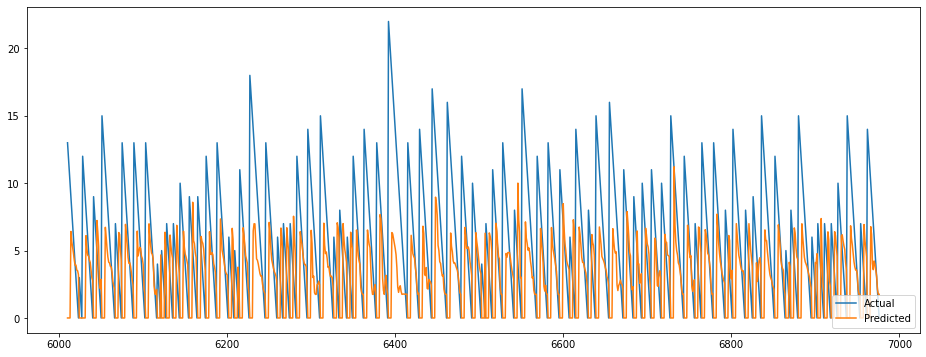

In [24]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal1)
plt.plot(valTimeLabels, predictedVal1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

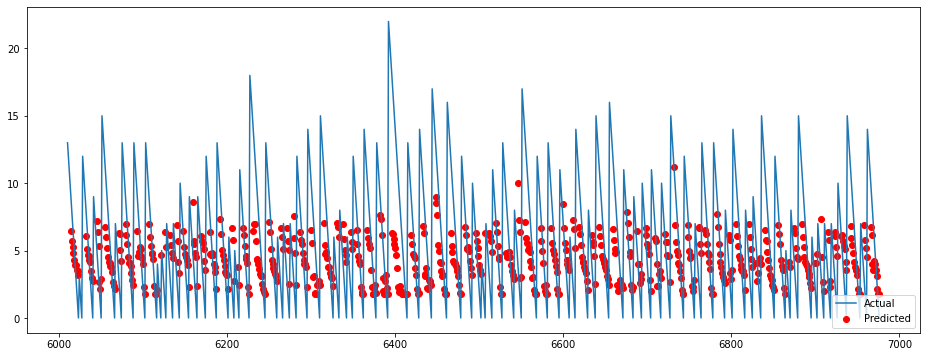

In [25]:
#validation set
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal1)
plt.scatter(valTime_4step_TAD, valPredict1, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

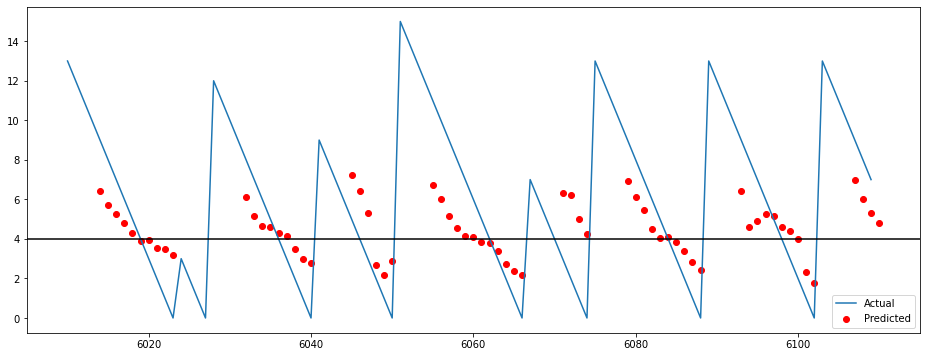

In [26]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal1[0:100])
plt.scatter(valTime_4step_TAD[0:65], valPredict1[0:65], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()